## Heston Model
This notebook demonstrates how to implement and visualize the Heston Model using the finmc library, specifically leveraging the class finmc.models.heston.HestonMC.
The Heston model is widely used in quantitative finance to model the stochastic volatility of asset prices.
By capturing volatility clustering and mean reversion, the Heston model serves as a key tool for pricing derivatives, managing portfolio risk, and understanding asset price dynamics over time.

In [7]:
from collections import Counter

from finmc.models.heston import HestonMC
from finmc.plots.asset import plot_asset
from finmc.utils.assets import flat_discount, flat_fwds

import plotly.graph_objects as go

Create dataset for this model. See [Heston Model Documentation](https://finlib.github.io/finmc/models/heston/) for explanation of model parameters.

In [8]:
# Step 1: Define the Dataset
asset_name = "SPX"
spot = 2900
rate = 0.02
# Create the base dataset for the Heston model
dataset = {
    "MC": {"PATHS": 100_000, "TIMESTEP": 1 / 250, "SEED": 1},
    "BASE": "USD",
    "ASSETS": {
        "USD": flat_discount(rate, 3.0),
        asset_name: flat_fwds(spot, rate, 0.0, 3.0),
    },
    "HESTON": {
        "ASSET": asset_name,
        "INITIAL_VAR": 0.02,
        "LONG_VAR": 0.04,  # Default LONG_VAR added here
        "VOL_OF_VOL": 0.45,
        "MEANREV": 1.5,
        "CORRELATION": -0.85,
    },
}


### Asset Price Simulation and Visualization
The notebook simulates the evolution of asset prices over time, driven by the dynamics of the Heston model.
A single simulation is conducted with default parameters to visualize how asset prices behave under the initial conditions.

Plot: Asset Evolution Over Time

This plot visualizes the time series evolution of the asset price.
It highlights how price paths behave under the initial volatility settings.

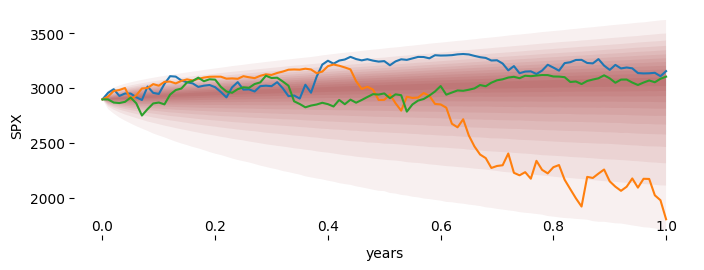

In [9]:
# Step 2: Initialize the Default Heston Model
model = HestonMC(dataset)

# Plot Asset Evolution (Default Dataset)
plot_asset(model, asset_name)

In [10]:
# Step 2: Initialize Heston Model
def categorize_price(price, bins):
    """Dynamically categorize a price into a bin based on user-defined bin edges."""
    for i, threshold in enumerate(bins):
        if price < threshold:
            return i  # Assign to the corresponding bin
    return len(bins)  # Assign to the highest bin if greater than all thresholds


def generate_flows(model, asset_name, times, bins):
    """Generates the flow matrix from simulated paths and bin classifications."""
    num_paths = dataset["MC"]["PATHS"]
    flows = Counter()

    # Generate asset paths and categorize them into bins
    model.reset()
    for t_idx, t in enumerate(times):
        model.advance(t)
        prices = model.get_value(asset_name)
        categories = [categorize_price(price, bins) for price in prices]

        if t_idx > 0:
            for prev, curr in zip(prev_categories, categories):
                flows[(t_idx - 1, prev, t_idx, curr)] += 1

        prev_categories = categories

    return flows

In [24]:
def plot_sankey(model, asset_name, times, bins):
    """Generates and plots a Sankey diagram based on price path transitions."""
    flows = generate_flows(model, asset_name, times, bins)

    # Find the unique coordinates
    unique_coords = set()
    for t1, b1, t2, b2 in flows.keys():
        unique_coords.add((t1, b1))
        unique_coords.add((t2, b2))
    unique_coords = list(unique_coords)

    # Create a dictionary to map coordinates to indices, and transform the flows into source/target/value lists
    coords_dict = {coord: i for i, coord in enumerate(unique_coords)}
    sources, targets, values = [], [], []
    for (t1, b1, t2, b2), count in flows.items():
        sources.append(coords_dict[(t1, b1)])
        targets.append(coords_dict[(t2, b2)])
        values.append(count)

    # Create labels, x and y positions for nodes
    bin_len = len(bins)
    def label_fn(t,b):
        if b == bin_len:
            return f"S>{bins[-1]:.0f}"
        if b == 0:
            return f"S<{bins[0]:.0f}"
        else:
            return f"{bins[b-1]:.0f}-{bins[b]:.0f}"


    labels = [label_fn(t,b) for (t,b) in unique_coords]
    x = [ times[t] for (t,b) in unique_coords]
    y = [ 1 - b * 0.4 for (t,b) in unique_coords]


    # Plot Sankey diagram
    fig = go.Figure(
        go.Sankey(
            # arrangement="snap",
            node=dict(
                label=labels,
                x=x,  # Explicitly set x positions
                y=y,  # Explicitly set y positions
            ),
            link=dict(
                source=sources,
                target=targets,
                value=values,
                # color="rgba(255,165,0,0.6)",
            ),
        )
    )
    # Annotate the time steps
    for t in times:
        fig.add_annotation(x=t, y=1., showarrow=True, text=f"t={t:.1f}")

    fig.update_layout(title_text="SPX Price Transitions", font_size=10, width=800, height=400)
    fig.show()

# Define dynamic bin sizes (e.g., spot * 1.2 and spot / 1.2), and time steps
bins = [spot / 1.1, spot * 1.1]
times = [0, 0.3, 0.7, 1.0]

# Call the function to plot Sankey
plot_sankey(model, asset_name, times, bins)